In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
seg_train_folders = '/content/drive/MyDrive/model-images/train/'
seg_test_folders = '/content/drive/MyDrive/model-images/test/'

Number of images in the train set :  1500
Number of images in test set :  3


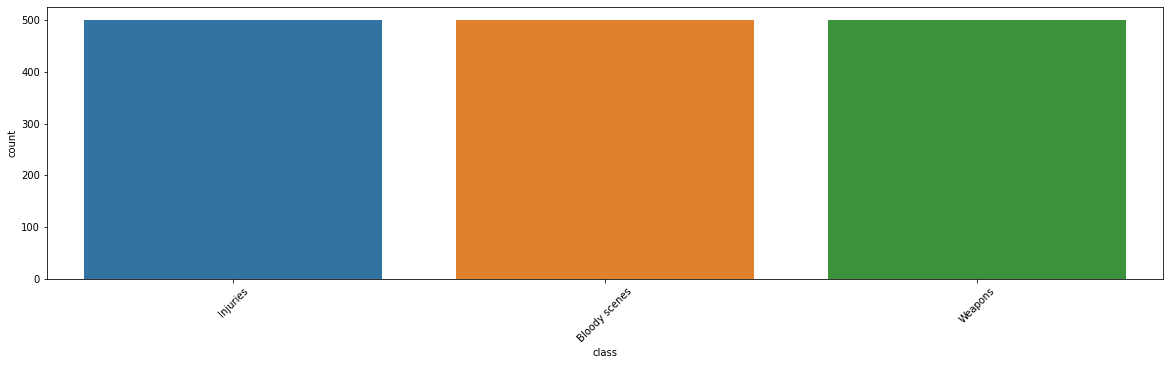

In [4]:


quantity_tr = {}

for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])

figure, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax)
plt.xticks(rotation=45)

print("Number of images in the train set : ", sum(quantity_tr.values()))
number_of_images_in_test_set = len(os.listdir(seg_test_folders))
print("Number of images in test set : ",number_of_images_in_test_set)

plt.show()

In [5]:

def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [6]:
data_generator = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = data_generator.flow_from_directory(seg_train_folders,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    subset="training")

validation_datagen = ImageDataGenerator(rescale = 1.0/255., validation_split=0.1) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_train_folders, shuffle=True, batch_size=64, class_mode='categorical', target_size=(150, 150), subset="validation")

Found 1500 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [7]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'Bloody scenes': 0, 'Injuries': 1, 'Weapons': 2}
{0: 'Bloody scenes', 1: 'Injuries', 2: 'Weapons'}


In [8]:
def show_few_images(number_of_examples=1, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(200,100*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

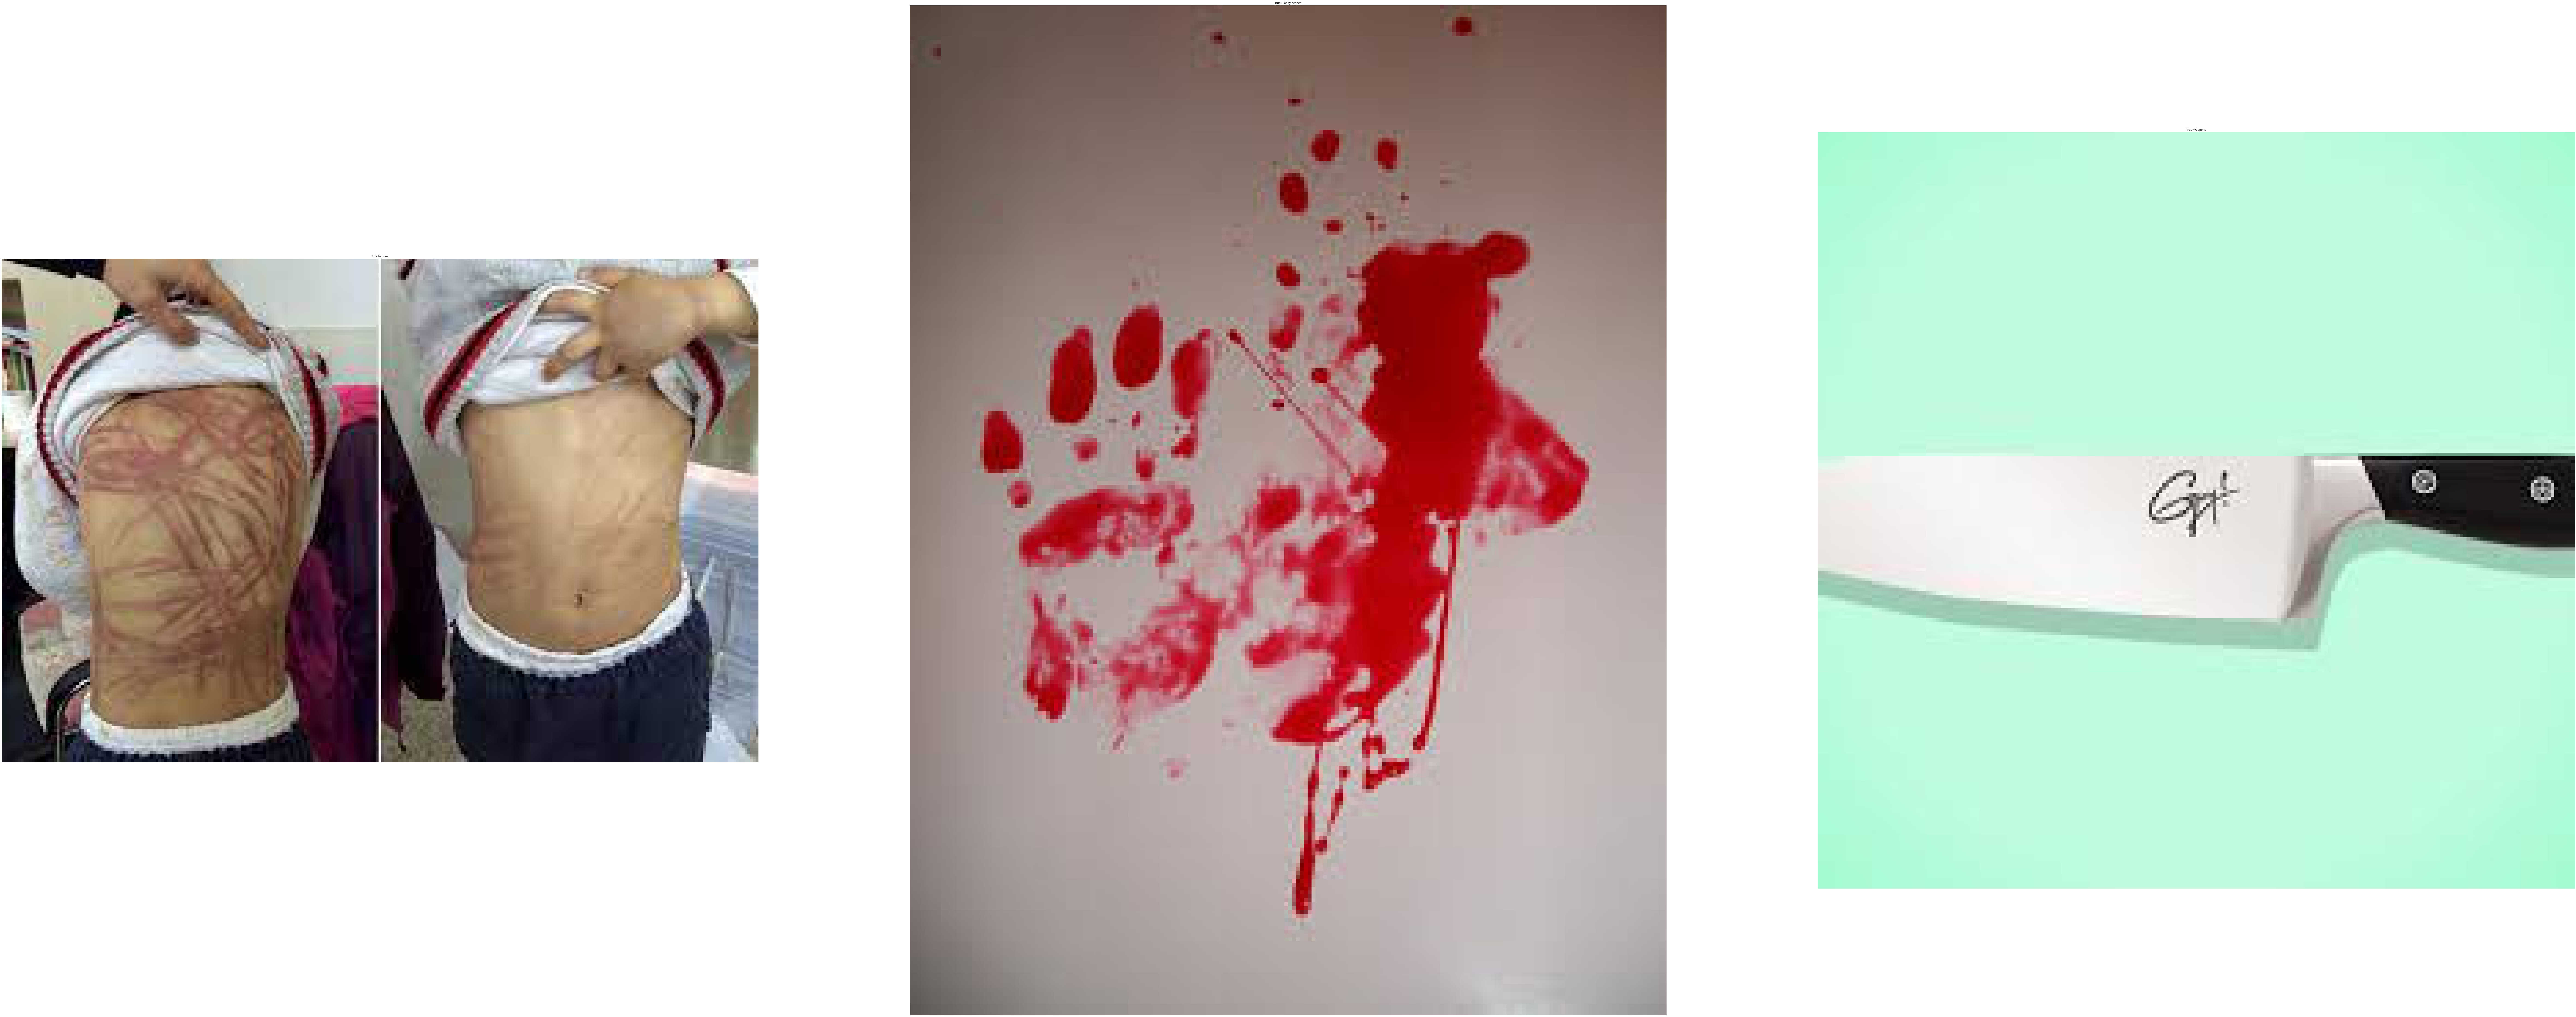

In [9]:
show_few_images(1)

In [10]:
tf.keras.backend.clear_session()

# epoch config
model_epoch = 8

In [11]:
# this could also be the output a different Keras model or layer

InceptionV3_model = InceptionV3(input_shape=(150, 150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True

InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.3)(InceptionV3_x)
InceptionV3_x = Dense(3, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = 10
inception_filepath = '/content/drive/MyDriveinceptionV3_model.h5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)


87910968/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.2489 - accuracy: 0.3880 

24/24 [==============================] - 300s 12s/step - loss: 1.2489 - accuracy: 0.3880 - val_loss: 1.2300 - val_accuracy: 0.4800
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.8336 - accuracy: 0.6347

24/24 [==============================] - 110s 5s/step - loss: 0.8336 - accuracy: 0.6347 - val_loss: 0.7604 - val_accuracy: 0.6800
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.7153

24/24 [==============================] - 108s 4s/step - loss: 0.6737 - accuracy: 0.7153 - val_loss: 0.6207 - val_accuracy: 0.7467
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7840

24/24 [==============================] - 108s 5s/step - loss: 0.5650 - accuracy: 0.7840 - val_loss: 0.5380 - val_accuracy: 0.8067
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.8200

24/24 [==============================] - 107s 4s/step - loss: 0.5066 - accuracy: 0.8200 - val_loss: 0.4903 - val_accuracy: 0.8133
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.8367

24/24 [==============================] - 107s 4s/step - loss: 0.4602 - accuracy: 0.8367 - val_loss: 0.4558 - val_accuracy: 0.8133
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.8467

24/24 [==============================] - 107s 4s/step - loss: 0.4385 - accuracy: 0.8467 - val_loss: 0.4286 - val_accuracy: 0.8267
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.8793

24/24 [==============================] - 107s 4s/step - loss: 0.3764 - accuracy: 0.8793 - val_loss: 0.3972 - val_accuracy: 0.8533
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.8700

24/24 [==============================] - 107s 5s/step - loss: 0.3605 - accuracy: 0.8700 - val_loss: 0.3835 - val_accuracy: 0.8600
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.8867

24/24 [==============================] - 114s 5s/step - loss: 0.3400 - accuracy: 0.8867 - val_loss: 0.3596 - val_accuracy: 0.8733


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


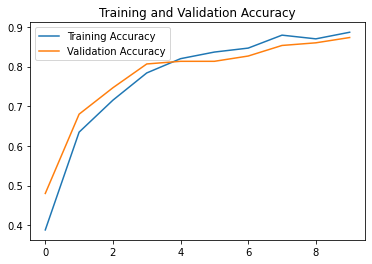

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


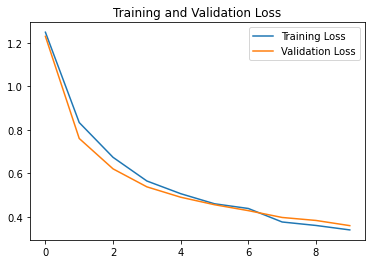

<Figure size 432x288 with 0 Axes>

In [16]:
do_history_stuff(inceptionv3_history, 'inceptionV3_model', True)

In [20]:
inceptionv3_history.model.save("/content/drive/MyDrive/models/inception_model.h5")

In [41]:

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
inception_pred = []

test_image_ids = os.listdir(seg_test_folders)

for image_id in test_image_ids:

    path = os.path.join(seg_test_folders,image_id)
    test_images = os.listdir(path)

    for image in test_images:
      true_value.append(validation_generator.class_indices[image_id])

      img = cv2.resize(cv2.imread(os.path.join(path,image)),(150,150))
      img_normalized = img/255
    
    #Inception
    inception_image_prediction = np.argmax(inceptionv3_history.model.predict(np.array([img_normalized])))
    inception_pred.append(inception_image_prediction)


1/1 [==============================] - 0s 88ms/step


In [49]:
model = keras.models.load_model("/content/drive/MyDrive/models/inception_model.h5")
img = cv2.resize(cv2.imread("/content/drive/MyDrive/images/b2.jfif"),(150,150))
img_normalized = img/255
model.predict(np.array([img_normalized]))

1/1 [==============================] - 1s 1s/step


array([[0.5147679 , 0.4763869 , 0.00884526]], dtype=float32)